In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose, Normalize
from torchvision.models import resnet18
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pickle as pkl

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
print("Using {} device".format(device))

Using cuda device


In [4]:
class LazyLoadDataset(Dataset):
    def __init__(self, path, train=True, transform=None):
        path = path + ("train/" if train else "test/")
        self.pathX = path + "X/"
        self.pathY = path + "Y/"
        self.transform = transform
        self.data = os.listdir(self.pathX)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        f = self.data[idx]
        img0 = cv2.imread(self.pathX + f + "/rgb/0.png")
        # Only normalize the first view, since it's what we only use
        img0 = (img0 - img0.mean()) / img0.std()
        img1 = cv2.imread(self.pathX + f + "/rgb/1.png")
        img2 = cv2.imread(self.pathX + f + "/rgb/2.png")
        depth = np.load(self.pathX + f + "/depth.npy")
        if self.transform:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
            img2 = self.transform(img2)
            depth = self.transform(depth)
        
        field_id = pkl.load(open(self.pathX + f + "/field_id.pkl", "rb"))
        # augment Y by 1000 to make training easier
        Y = np.load(self.pathY + f + ".npy") * 1000
        return (img0, img1, img2, depth, field_id), Y

In [5]:
dataset = LazyLoadDataset("/kaggle/input/lazy-data/lazydata/", train=True, transform=ToTensor())
(img0, img1, img2, depth, field_id), Y = dataset[0]
print(img0.shape, img1.shape, img2.shape, depth.shape)
print(field_id)
print(Y)

torch.Size([3, 224, 224]) torch.Size([3, 224, 224]) torch.Size([3, 224, 224]) torch.Size([224, 3, 224])
488
[ 54.99868702  52.67679282 114.35164248  80.80994214  -4.69584664
  83.05545561  69.34497465 -50.61545976  95.72397293  46.90143058
  89.92971756 -11.60888304]


In [6]:
train_dataset = LazyLoadDataset("/kaggle/input/lazy-data/lazydata/", train=True, transform=ToTensor())
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [7]:
for X, Y in train_loader:
    print(X[0].shape, X[1].shape, X[2].shape, X[3].shape, len(X[4]))
    print(Y.shape)
    print(type(X[0]), type(X[1]), type(X[2]), type(X[3]), type(X[4]))
    break

torch.Size([64, 3, 224, 224]) torch.Size([64, 3, 224, 224]) torch.Size([64, 3, 224, 224]) torch.Size([64, 224, 3, 224]) 64
torch.Size([64, 12])
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'> <class 'tuple'>


In [8]:
# CNN model (2 conv layer, 3 fully connected layer, 2 dropout layer)
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 53 * 53, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 12)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 53 * 53)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = CNN().to(device)

In [9]:
# fine-tune resnet18 model (unsuccessful, incomplete)
class ResNet18(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = resnet18(pretrained=True)
        self.model.fc = nn.Linear(512, 12)

    def forward(self, x):
        return self.model(x)
        
resnet18_model = ResNet18().to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [10]:
# Use RMSE as loss function
def rmse_loss(pred, target):
    return torch.sqrt(torch.mean((pred - target) ** 2))
loss_fn = rmse_loss

# Use Stochastic Gradient Descent as optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [14]:
def train(dataloader, model, loss_fn, optimizer, loss_record):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        X[0] = X[0].to(device)
        y = y.to(device)

        pred = model(X[0].float())
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X[0])
            loss_record.append(loss)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [15]:
# train for 40 epochs
epoch = 40
loss_record = []
for t in range(epoch):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_loader, model, loss_fn, optimizer, loss_record)
print("Done!")

Epoch 1
-------------------------------
loss: 66.203677  [    0/ 3396]
Epoch 2
-------------------------------
loss: 66.496954  [    0/ 3396]
Epoch 3
-------------------------------
loss: 63.065137  [    0/ 3396]
Epoch 4
-------------------------------
loss: 22.258577  [    0/ 3396]
Epoch 5
-------------------------------
loss: 21.396658  [    0/ 3396]
Epoch 6
-------------------------------
loss: 17.686162  [    0/ 3396]
Epoch 7
-------------------------------
loss: 15.961809  [    0/ 3396]
Epoch 8
-------------------------------
loss: 12.081941  [    0/ 3396]
Epoch 9
-------------------------------
loss: 19.336769  [    0/ 3396]
Epoch 10
-------------------------------
loss: 26.252907  [    0/ 3396]
Epoch 11
-------------------------------
loss: 21.026123  [    0/ 3396]
Epoch 12
-------------------------------
loss: 20.977135  [    0/ 3396]
Epoch 13
-------------------------------
loss: 16.762142  [    0/ 3396]
Epoch 14
-------------------------------
loss: 27.292912  [    0/ 3396]
E

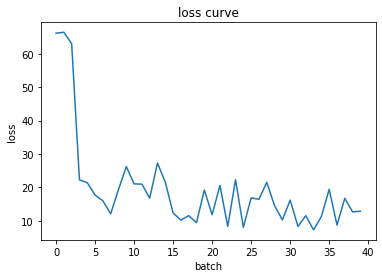

In [16]:
# loss vs epoch
plt.plot(loss_record)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("loss curve")
plt.show()

In [17]:
import pickle
import pandas as pd

outfile = 'submission.csv'

output_file = open(outfile, 'w')

titles = ['ID', 'FINGER_POS_1', 'FINGER_POS_2', 'FINGER_POS_3', 'FINGER_POS_4', 'FINGER_POS_5', 'FINGER_POS_6',
         'FINGER_POS_7', 'FINGER_POS_8', 'FINGER_POS_9', 'FINGER_POS_10', 'FINGER_POS_11', 'FINGER_POS_12']
preds = []

test_data = torch.load('/kaggle/input/test-x2/testX.pt')
print(test_data[1].shape)
file_ids = test_data[-1]
rgb_data = test_data[0].to(device)

print(rgb_data.shape)

torch.Size([849, 3, 224, 224])
torch.Size([849, 3, 3, 224, 224])


In [18]:
model.eval()

for i, data in enumerate(rgb_data):
    # Please remember to modify this loop, input and output based on your model/architecture
    # Normalize X data in the same way as did in training
    data[0] = (data[0] - data[0].mean()) / data[0].std()
    # Divide output by 1000 to get the original scale
    output = model(data[0]) / 1000
    preds.append(output[0].cpu().detach().numpy())

df = pd.concat([pd.DataFrame(file_ids), pd.DataFrame.from_records(preds)], axis = 1, names = titles)
df.columns = titles
df.to_csv(outfile, index = False)
print("Written to csv file {}".format(outfile))

Written to csv file submission.csv
